In [126]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy.linalg as la

In [127]:
# Below snippit taken from PyTorch quickstart tutorial
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


In [128]:
class DecisionDataset(Dataset):
    def __init__(self, n_trials, n_time_step=75):   
        """
        Generate perceptual decision-making data.

        Parameters
        ----------
        n_trials : int
            Number of trials.
        n_time_step : int (Default: 75)
            Number of time steps.
        Returns
        -------
        u : array, shape (n_trials,n_time_step)
            input 
        y : array, shape (n_trials,n_time_step)
            output 
        """
        strength_choices = (3.2/ 100)  * np.array([1,2,4,8,16, -1,-2,-4,-8,-16])
        n_time_step = 75
        time_step= 20 #ms

        u = np.zeros([n_trials,n_time_step])
        y = np.zeros([n_trials,n_time_step])

        for trial in range(n_trials):
            strength = np.random.choice(strength_choices)

            for t in range(0,n_time_step):
                if t>=5 and t<=45:
                    #noise with std 0.03
                    u[trial,t] = strength + np.random.normal(0,0.03)
                else:
                    u[trial, t] = np.random.normal(0,0.03)

                y[trial, t] = np.sign(strength)
        
        self.u = torch.tensor(u, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.n_trials = n_trials
        
    def __len__(self):
        return self.n_trials
    
    def __getitem__(self, idx):
        return self.u[idx,:], self.y[idx,:]

In [142]:
class RNN(nn.Module):
    
    def __init__(self, network_size=128,rank=1):
        
        super(RNN, self).__init__()
        self.network_size = network_size
        self.rank=rank
        
        # Weight initialization
        #unit rank rnn weight matrix J=mn^T/n
        if rank==1:
            self.m = nn.Parameter(torch.Tensor(self.network_size))
            self.n = nn.Parameter(torch.Tensor(self.network_size))
            self.wi = torch.Tensor(self.network_size)
            self.w = torch.Tensor(self.network_size)
            self.x0= torch.Tensor(self.network_size)
        else:
            self.m = nn.Parameter(torch.Tensor(self.network_size,self.rank))
            self.n = nn.Parameter(torch.Tensor(self.network_size,self.rank))
            self.wi = torch.Tensor(self.network_size, self.rank)
            self.w = torch.Tensor(self.network_size,1)
            self.x0= torch.Tensor(self.network_size,1)
        
                # Parameters for weight update formula
        self.tau = 100 #ms
        self.dt = 20 #ms

        # Activation function
        self.activation = nn.Tanh()
        
        with torch.no_grad():
            self.m.normal_(std=1)
            self.n.normal_(std=1)           
            self.w.normal_(std=4)
            self.x0.zero_()
            self.wi.normal_(std=1)

    def forward(self, u,visible_activity=False):
        input_len=u.size(1)
        batch_size=u.size(0)
        x = self.x0 
        z = torch.zeros(u.shape)
        
        r = self.activation(x)
        
        if visible_activity:
            unit_activity = torch.zeros(batch_size, input_len+1, self.network_size)
            unit_activity[:,0,:] = x
        
        #unit rank rnn weight matrix J=mn^T/n
        # J = torch.matmul(self.m[:,None], self.n[None,:]) / self.network_size
        
        for i in range(input_len):
            delta_x = (
                -x 
                + r.matmul(self.n[:,None]).matmul(self.m[:,None].t()) / self.network_size 
                
                + torch.matmul(u[:,i,None], self.wi[None,:])
            ) * (self.dt / self.tau)
            
            x = x + delta_x
            r = self.activation(x)
            if visible_activity:
                unit_activity[:,i+1,:] = x
            
            output = torch.matmul(self.activation(x), self.w) / self.network_size            
            z[:, i] = output    
            
        if visible_activity:
            return z, unit_activity
        else:
            return z
        
    def get_mean_cov(self):
        """
        Returns the mean and covariance matrix of internal
        parameters in the form [wi, n, m, w]
        """
        m=self.m.detach().numpy()
        n=self.n.detach().numpy()
        wi=self.wi.detach().numpy()
        w=self.w.detach().numpy()
        vectors = [wi, n, m, w]

        mean = np.mean(vectors, axis=1)
        cov_matrix=np.cov(vectors)
        
        return torch.tensor(mean), torch.tensor(cov_matrix)

In [138]:
# Training function slightly modified from PyTorch quickstart tutorial
def train(dataloader, model, loss_fn, optimizer, T=15):
    size = len(dataloader.dataset)
    optimizer.zero_grad()
    model.train(True)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # print("pred shape: ", pred.shape)
        loss = loss_fn(pred[:,-T:], y[:,-T:])

        # print(pred[0, :])
        # print(pred[0, -T:])
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [167]:
d_dataset = DecisionDataset(1000)
train_dataloader = DataLoader(d_dataset, batch_size=1)
model = RNN(128)
learning_rate = 5e-3
T=15
# model = RNN(128)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(train_dataloader, model, loss_fn, optimizer, T=T)

loss: 1.001011  [    1/ 1000]
loss: 0.985635  [  101/ 1000]
loss: 0.000090  [  201/ 1000]
loss: 0.000689  [  301/ 1000]
loss: 0.000104  [  401/ 1000]
loss: 0.000015  [  501/ 1000]
loss: 0.000285  [  601/ 1000]
loss: 0.012048  [  701/ 1000]
loss: 0.001503  [  801/ 1000]
loss: 0.001410  [  901/ 1000]


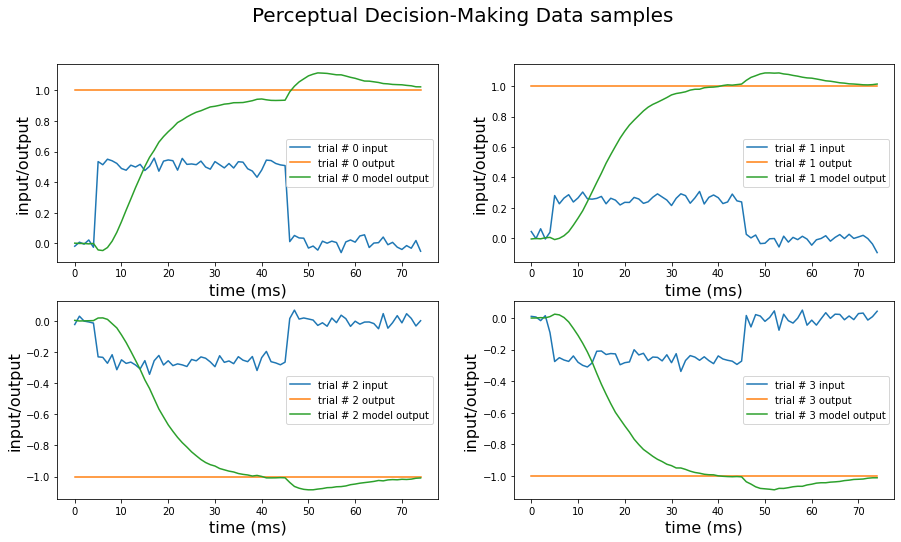

In [168]:
d_data = DecisionDataset(1000)
d_dataloader = DataLoader(d_data, batch_size=4)
u_arr, y_arr = next(iter(d_dataloader))

plt.figure(figsize=(15,8))
plt.suptitle('Perceptual Decision-Making Data samples', fontsize=20)
for idx in range(4):
    plt.subplot(2,2,idx+1)
    plt.plot(u_arr[idx,:], label='trial # {} input'.format(idx))
    plt.plot(y_arr[idx,:], label='trial # {} output'.format(idx))
    plt.plot(model(u_arr[idx,:].unsqueeze(0)).detach().numpy().squeeze(), label='trial # {} model output'.format(idx))
    plt.xlabel('time (ms)', fontsize=16)
    #dt = 20msb
    # plt.xticks(np.arange(0, 75, step=5), np.arange(0, 1500, step=100))
    plt.ylabel('input/output', fontsize=16)
    plt.legend()

[[ 1.08215292 -0.54577863 -0.16344786 -0.29172726]
 [-0.54577863  1.86432992  1.30228449 -0.68123606]
 [-0.16344786  1.30228449  1.96179737 -2.3097842 ]
 [-0.29172726 -0.68123606 -2.3097842  14.98415224]]
tensor([-0.1694,  0.3717,  0.0600,  0.5827])
[[ 1.08215292 -0.54577863 -0.16344786 -0.29172726]
 [-0.54577863  1.86432992  1.30228449 -0.68123606]
 [-0.16344786  1.30228449  1.96179737 -2.3097842 ]
 [-0.29172726 -0.68123606 -2.3097842  14.98415224]]
[[-0.54577863 -0.16344786 -0.29172726]
 [ 0.          1.30228449 -0.68123606]
 [ 0.          0.         -2.3097842 ]]


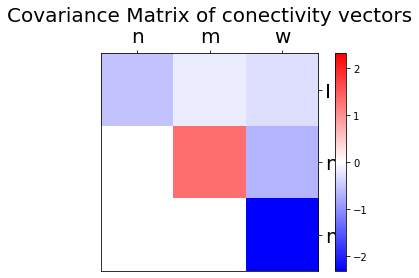

In [169]:
m=model.m.detach().numpy()
n=model.n.detach().numpy()
wi=model.wi.detach().numpy()
w=model.w.detach().numpy()
network_size=model.network_size
# m=-m
# n=-n
vectors = [wi, n, m, w]

cov_matrix=np.cov(vectors)
print(cov_matrix)

mean, cov_mat2 = model.get_mean_cov()
print(mean)
print(cov_matrix)

cov_matrix = cov_mat2.numpy()

cov_matrix=np.triu(cov_matrix,1)
cov_matrix=cov_matrix[0:3,1:4]
bound = np.max((np.abs(np.min(cov_matrix)), np.abs(np.max(cov_matrix))))

print(cov_matrix)

plt.figure()
ax=plt.gca()
ax.yaxis.tick_right()
ax.xaxis.tick_top()
plt.title('Covariance Matrix of conectivity vectors', fontsize=20)
plt.imshow(cov_matrix,cmap= "bwr", vmin=-bound, vmax=bound)
ax.set_aspect('equal','box')
plt.xticks(np.arange(0, 3, step=1), ['n', 'm', 'w'], fontsize=20)
plt.yticks(np.arange(0, 3, step=1), ['I','n', 'm'], fontsize=20)
plt.colorbar()

In [170]:
from torch.distributions.multivariate_normal import MultivariateNormal

class FittedRankOneRNN(nn.Module):
    
    def __init__(self, mean, cov_mat, network_size=128):
        
        super(FittedRankOneRNN, self).__init__()
        self.network_size = network_size
        self.rank=1
        self.mean = mean
        self.cov_mat = cov_mat
        
        mean = mean.numpy()
        cov_mat = cov_mat.numpy()
        
        params = np.random.multivariate_normal(mean, cov_mat, size=network_size)
        self.m = torch.tensor(params[:,2], dtype=torch.float)
        self.n = torch.tensor(params[:,1], dtype=torch.float)
        self.wi = torch.tensor(params[:,0], dtype=torch.float)
        self.w = torch.tensor(params[:,3], dtype=torch.float)
        self.x0 = torch.zeros(network_size, dtype=torch.float)
        
        # Parameters for weight update formula
        self.tau = 100 #ms
        self.dt = 20 #ms

        # Activation function
        self.activation = nn.Tanh()
        
        
    def forward(self, u,visible_activity=False):
        input_len=u.size(1)
        batch_size=u.size(0)
        x = self.x0 
        z = torch.zeros(u.shape)
        
        r = self.activation(x)
        
        if visible_activity:
            unit_activity = torch.zeros(batch_size, input_len+1, self.network_size)
            unit_activity[:,0,:] = x
        
        #unit rank rnn weight matrix J=mn^T/n
        # J = torch.matmul(self.m[:,None], self.n[None,:]) / self.network_size
        
        for i in range(input_len):
            delta_x = (
                -x 
                + r.matmul(self.n[:,None]).matmul(self.m[:,None].t()) / self.network_size       
                + torch.matmul(u[:,i,None], self.wi[None,:])
            ) * (self.dt / self.tau)
            
            x = x + delta_x
            r = self.activation(x)
            if visible_activity:
                unit_activity[:,i+1,:] = x
            
            output = torch.matmul(self.activation(x), self.w) / self.network_size            
            z[:, i] = output    
            
        if visible_activity:
            return z, unit_activity
        else:
            return z

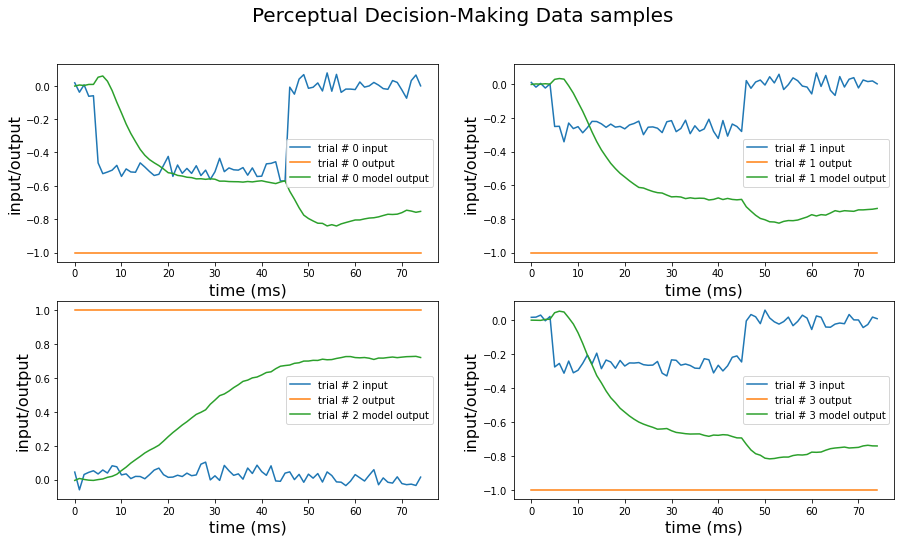

In [171]:
mean, cov_mat = model.get_mean_cov()
fit_model = FittedRankOneRNN(mean, cov_mat)

d_data = DecisionDataset(1000)
d_dataloader = DataLoader(d_data, batch_size=4)
u_arr, y_arr = next(iter(d_dataloader))

plt.figure(figsize=(15,8))
plt.suptitle('Perceptual Decision-Making Data samples', fontsize=20)
for idx in range(4):
    plt.subplot(2,2,idx+1)
    plt.plot(u_arr[idx,:], label='trial # {} input'.format(idx))
    plt.plot(y_arr[idx,:], label='trial # {} output'.format(idx))
    plt.plot(fit_model(u_arr[idx,:].unsqueeze(0)).detach().numpy().squeeze(), label='trial # {} model output'.format(idx))
    plt.xlabel('time (ms)', fontsize=16)
    #dt = 20msb
    # plt.xticks(np.arange(0, 75, step=5), np.arange(0, 1500, step=100))
    plt.ylabel('input/output', fontsize=16)
    plt.legend()